
<br>
<font>
<!-- <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" alt="SUT logo" width=300 height=300 align=left class="saturate"> -->
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=200 height=200>
<br>
<font color=0F5298 size=7>
Machine Learning <br>
<font color=2565AE size=5>
Electrical Engineering Department <br>
Spring 2024<br>
<font color=3C99D size=5>
Practical Assignment 4 <br>
<font color=696880 size=4>
<!-- <br> -->


____

# Personal Data

In [1]:
student_number = 400101837
first_name = 'Ali'
last_name = 'Kouchakzade'

# Introduction

In this assignment, we will be performing clustering on Spotify songs.

# Data Preprocessing

In the next cell, import the libraries you'll need.

In [2]:
# TODO: Write your code here
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import random
from sklearn.metrics import silhouette_score

In the `spotify.csv` file, load the data. Exclude unrelated features and retain only the track name and the features you believe are relevant.

In [27]:
# TODO: Write your code here
data_all = pd.read_csv('/content/spotify.csv')
data_all = data_all.drop(columns=['track_id','track_album_id','playlist_id','track_album_release_date','track_artist',
                          'track_album_name'])
display(data_all.head())
data = data_all.to_numpy()
data_track_name = data[:,0]
data = data[:,1:]

,track_name,track_popularity,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,I Don't Care (with Justin Bieber) - Loud Luxur...,66,Pop Remix,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,Memories - Dillon Francis Remix,67,Pop Remix,pop,dance pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,All the Time - Don Diablo Remix,70,Pop Remix,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,Call You Mine - Keanu Silva Remix,60,Pop Remix,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,Someone You Loved - Future Humans Remix,69,Pop Remix,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In this cell, you should implement a standard scalar function from scratch and applying it to your data. Explian importance behind using a standard scalar and the potential complications that could arise in clustering if it's not employed. (you can't use `sklearn.preprocessing.StandardScaler` but you are free to use `sklearn.preprocessing.LabelEncoder`)

In [85]:
# TODO: Write your code here
le = LabelEncoder()
data[:,1] = le.fit_transform(data[:,1])
data[:,2] = le.fit_transform(data[:,2])
data[:,3] = le.fit_transform(data[:,3])
data = data.astype(np.float64)

data_std = np.std(data,axis=0)
data_mean = np.mean(data,axis=0)
data = (data - data_mean) / data_std

print(data.shape)

(32833, 16)


# Dimensionality Reduction

One method for dimensionality reduction is Principal Component Analysis (PCA). Use its implementation from the `sklearn` library to reduce the dimensions of your data. Then, by using an appropriate cut-off for the `_explained_variance_ratio_` in the PCA algorithm, determine the number of principal components to retain.

In [86]:
# TODO: Write your code here
cutoff = 0.83

pca = PCA()
pca.fit(data)

num_components = (pca.explained_variance_ratio_.cumsum() < cutoff).sum() + 1
pca = PCA(n_components=num_components)
data_pca = pca.fit_transform(data)
data_pca.shape

(32833, 11)

# Clustering

Implement K-means for clustering from scratch.

In [7]:
# TODO: Write your code here
def cluster(X, K):
    m , n = X.shape
    C = np.zeros((K, n))

    C[0] = X[np.random.randint(m)]

    distances = np.linalg.norm(X - C[0], axis=1)

    for i in range(1, K):
        probabilities = distances ** 2 / np.sum(distances ** 2)
        cumulative_probabilities = np.cumsum(probabilities)
        r = np.random.rand()
        next_centroid_idx = np.searchsorted(cumulative_probabilities, r)
        C[i] = X[next_centroid_idx]

        new_distances = np.linalg.norm(X - C[i], axis=1)
        distances = np.minimum(distances, new_distances)

    error = np.array([np.inf, 0])
    for _ in range(1000):
        U = np.array([], dtype=np.int32)

        for point in X:
            dist = np.array([np.linalg.norm(point - center) for center in C])
            point_assigned_center = np.argmin(dist)
            U = np.append(U, point_assigned_center)

        for k in range(K):
            index_k = np.where(U == k)[0]
            X_k = X[index_k]
            C[k,:] = np.mean(X_k, axis=0)

        error[1] , error[0] = error[0] , 0
        for indx,point in enumerate(X):
            error[0] += np.linalg.norm(point - C[U[indx]])

        if error[1] - error[0] < 1e-5:
            break

    return C, U,error[0] / m

Using the function you've created to execute the K-means algorithm eight times on your data, with the number of clusters ranging from 2 to 9. For each run, display the genre of each cluster using the first two principal components in a plot.

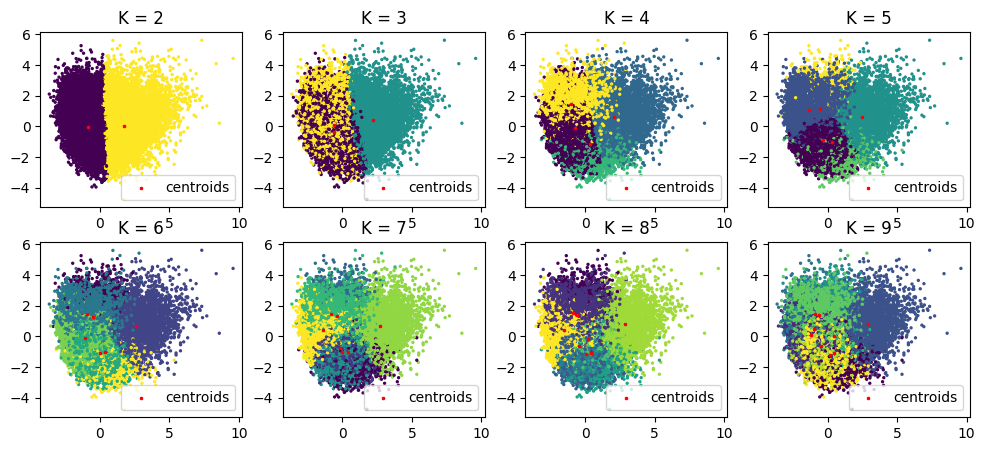

In [10]:
# TODO: Write your code here
plt.figure(figsize=(12,5))
clusters = np.zeros((8, data_pca.shape[0]))
wss_list = []
for k in range(2,10):
    C, U , WSS = cluster(data_pca, K= k)
    wss_list.append(WSS)
    clusters[k - 2, :] = U
    plt.subplot(2,4,k-1)
    plt.scatter(data_pca[:,0], data_pca[:,1], c=U, s=2)
    plt.scatter(C[:,0],C[:,1], marker='x', c='r', s=3, label='centroids')
    plt.legend()
    plt.title(f'K = {k}')
plt.show()

The Silhouette score and the Within-Cluster Sum of Squares (WSS) score are two metrics used to assess the quality of your clustering. You can find more information about these two methods [here](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb). Plot the Silhouette score and the WSS score for varying numbers of clusters, and use these plots to determine the optimal number of clusters (k).

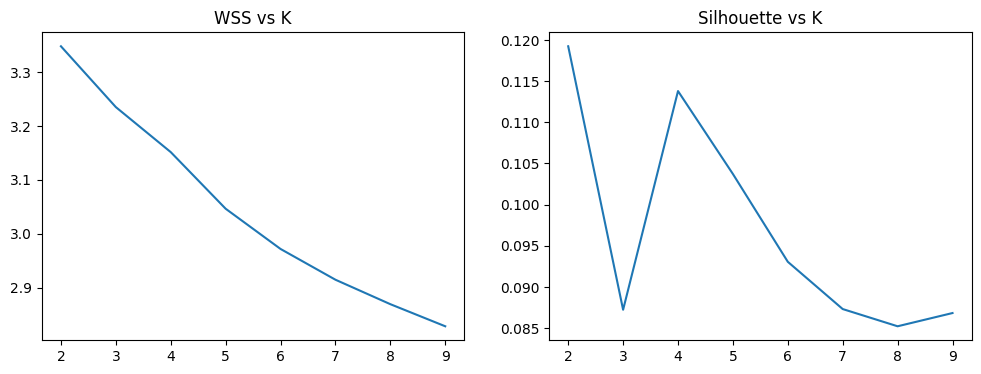

optimal number of clusters is K = 4


In [11]:
# TODO: Write your code here
K = np.arange(2,10)
sil_list = []

for k in K:
    SIL = silhouette_score(data_pca,clusters[k-2,:],metric='euclidean')
    sil_list.append(SIL)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K, wss_list)
plt.title('WSS vs K')
plt.subplot(1,2,2)
plt.plot(K, sil_list)
plt.title('Silhouette vs K')
plt.show()

# elbow point in WSS is at K = 4 and silhouette score shows best K = 4
optimal_K = 4
print('optimal number of clusters is K = 4')

# Checking Output

To see how good was our clustering we will use a sample check and t-SNE method.

first randomly select two song from every cluster and see how close these two songs are.

In [82]:
# TODO: Write your code here
output = clusters[optimal_K-2,:]
for i in range(optimal_K):
    index = np.where(output == i)[0]
    selected = np.random.choice(index, 2, replace=False)
    track_name_selected = (data_track_name[selected])
    print(f'from cluster {i} selected two songs {track_name_selected} \n')
    display(data_all.iloc[selected])
    print('\n\n')

from cluster 0 selected two songs ['Es Por Tí' 'Let U Go'] 



,track_name,track_popularity,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
18049,Es Por Tí,0,Latin Pop antiguo,latin,latin pop,0.695,0.764,4,-6.084,1,0.0264,0.187,0.000027,0.172,0.836,129.945,252693
18550,Let U Go,36,Exitos 2020 - Latin Billboard,latin,latin pop,0.680,0.548,8,-5.523,0,0.0697,0.389,0.000000,0.115,0.447,109.591,211636





from cluster 1 selected two songs ['Mr. Banker - Single Version' 'Fool Myself (feat. Welms)'] 



,track_name,track_popularity,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
13062,Mr. Banker - Single Version,0,Southern Rock/Classic Rock,rock,classic rock,0.472,0.218,4,-12.376,1,0.0284,0.960,0.0197,0.1050,0.353,79.445,319533
16763,Fool Myself (feat. Welms),47,Tropical House 🏝 2020 Hits,latin,tropical,0.540,0.490,7,-7.254,1,0.0413,0.214,0.0000,0.0991,0.379,104.912,175996





from cluster 2 selected two songs ["Ain't Gonna Let Up" 'Paid In Full'] 



,track_name,track_popularity,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
7046,Ain't Gonna Let Up,9,Dirty South Rap Classics by DJ HOTSAUCE,rap,southern hip hop,0.820,0.514,11,-4.330,0,0.230,0.53300,0.00000,0.2140,0.780,150.041,194747
7807,Paid In Full,51,Minitruckin Playlist,rap,southern hip hop,0.878,0.851,7,-8.971,1,0.232,0.00228,0.00125,0.0509,0.404,99.014,228667





from cluster 3 selected two songs ['Making Me Dizzy' 'Violence - Original Mix'] 



,track_name,track_popularity,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
29034,Making Me Dizzy,0,big boom room — TOMORROWLAND EDC EDM BIG ROOM ...,edm,big room,0.596,0.973,6,-4.307,1,0.0851,0.00136,0.561,0.4210,0.646,126.002,188239
26839,Violence - Original Mix,24,Electro House 2020,edm,electro house,0.745,0.938,7,-3.877,1,0.0695,0.00186,0.946,0.0915,0.686,128.034,289000


Using t-SNE reduce dimension of data pointe to 2D and plot it to check how good datapoints are clustered (implementing this part is optional and have extra points)

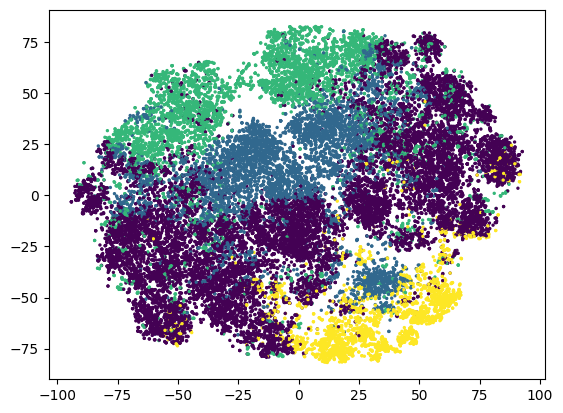

In [91]:
# TODO: Write your code here
from sklearn.manifold import TSNE

data_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=45).fit_transform(data)
plt.scatter(data_embedded[:,0],data_embedded[:,1],c = clusters[optimal_K-2,:],s=2)
plt.show()